# Optimal Investment

```{include} _admonition/gpu.md
```

We require the following library to be installed.

In [1]:
!pip install --upgrade quantecon

We study a monopolist who faces inverse demand curve

$$
P_t = a_0 - a_1 Y_t + Z_t,
$$

where

* $P_t$ is price,
* $Y_t$ is output and
* $Z_t$ is a demand shock.

We assume that $Z_t$ is a discretized AR(1) process, specified below.

Current profits are

$$ P_t Y_t - c Y_t - \gamma (Y_{t+1} - Y_t)^2 $$

Combining with the demand curve and writing $y, y'$ for $Y_t, Y_{t+1}$, this becomes

$$    r(y, z, y') := (a_0 - a_1  y + z - c) y - γ  (y' - y)^2 $$

The firm maximizes present value of expected discounted profits.  The Bellman equation is

$$   v(y, z) = \max_{y'} \left\{ r(y, z, y') + β \sum_{z'} v(y', z') Q(z, z') \right\}. $$

We discretize $y$ to a finite grid `y_grid`.

In essence, the firm tries to choose output close to the monopolist profit maximizer, given $Z_t$, but is constrained by adjustment costs.

Let's begin with the following imports

In [2]:
import quantecon as qe
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

Let's check the GPU we are running

In [3]:
!nvidia-smi

/opt/conda/envs/quantecon/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Thu Mar  7 02:00:02 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 12.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   29C    P0    37W / 300W |      0MiB / 16160MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+


We will use 64 bit floats with JAX in order to increase the precision.

In [4]:
jax.config.update("jax_enable_x64", True)

Let's define a function to create an investment model using the given parameters.

In [5]:
def create_investment_model(
        r=0.01,                              # Interest rate
        a_0=10.0, a_1=1.0,                   # Demand parameters
        γ=25.0, c=1.0,                       # Adjustment and unit cost
        y_min=0.0, y_max=20.0, y_size=100,   # Grid for output
        ρ=0.9, ν=1.0,                        # AR(1) parameters
        z_size=150):                         # Grid size for shock
    """
    A function that takes in parameters and returns an instance of Model that
    contains data for the investment problem.
    """
    β = 1 / (1 + r)
    y_grid = jnp.linspace(y_min, y_max, y_size)
    mc = qe.tauchen(z_size, ρ, ν)
    z_grid, Q = mc.state_values, mc.P

    # Break up parameters into static and nonstatic components
    constants = β, a_0, a_1, γ, c
    sizes = y_size, z_size
    arrays = y_grid, z_grid, Q

    # Shift arrays to the device (e.g., GPU)
    arrays = tuple(map(jax.device_put, arrays))
    return constants, sizes, arrays

Let's re-write the vectorized version of the right-hand side of the
Bellman equation (before maximization), which is a 3D array representing

$$
    B(y, z, y') = r(y, z, y') + \beta \sum_{z'} v(y', z') Q(z, z')
$$

for all $(y, z, y')$.

In [6]:
def B(v, constants, sizes, arrays):
    """
    A vectorized version of the right-hand side of the Bellman equation
    (before maximization)
    """

    # Unpack
    β, a_0, a_1, γ, c = constants
    y_size, z_size = sizes
    y_grid, z_grid, Q = arrays

    # Compute current rewards r(y, z, yp) as array r[i, j, ip]
    y  = jnp.reshape(y_grid, (y_size, 1, 1))    # y[i]   ->  y[i, j, ip]
    z  = jnp.reshape(z_grid, (1, z_size, 1))    # z[j]   ->  z[i, j, ip]
    yp = jnp.reshape(y_grid, (1, 1, y_size))    # yp[ip] -> yp[i, j, ip]
    r = (a_0 - a_1 * y + z - c) * y - γ * (yp - y)**2

    # Calculate continuation rewards at all combinations of (y, z, yp)
    v = jnp.reshape(v, (1, 1, y_size, z_size))  # v[ip, jp] -> v[i, j, ip, jp]
    Q = jnp.reshape(Q, (1, z_size, 1, z_size))  # Q[j, jp]  -> Q[i, j, ip, jp]
    EV = jnp.sum(v * Q, axis=3)                 # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return r + β * EV

# Create a jitted function
B = jax.jit(B, static_argnums=(2,))

We define a function to compute the current rewards $r_\sigma$ given policy $\sigma$,
which is defined as the vector

$$ r_\sigma(y, z) := r(y, z, \sigma(y, z)) $$

In [7]:
def compute_r_σ(σ, constants, sizes, arrays):
    """
    Compute the array r_σ[i, j] = r[i, j, σ[i, j]], which gives current
    rewards given policy σ.
    """

    # Unpack model
    β, a_0, a_1, γ, c = constants
    y_size, z_size = sizes
    y_grid, z_grid, Q = arrays

    # Compute r_σ[i, j]
    y = jnp.reshape(y_grid, (y_size, 1))
    z = jnp.reshape(z_grid, (1, z_size))
    yp = y_grid[σ]
    r_σ = (a_0 - a_1 * y + z - c) * y - γ * (yp - y)**2

    return r_σ


# Create the jitted function
compute_r_σ = jax.jit(compute_r_σ, static_argnums=(2,))

Define the Bellman operator.

In [8]:
def T(v, constants, sizes, arrays):
    """The Bellman operator."""
    return jnp.max(B(v, constants, sizes, arrays), axis=2)

T = jax.jit(T, static_argnums=(2,))

The following function computes a v-greedy policy.

In [9]:
def get_greedy(v, constants, sizes, arrays):
    "Computes a v-greedy policy, returned as a set of indices."
    return jnp.argmax(B(v, constants, sizes, arrays), axis=2)

get_greedy = jax.jit(get_greedy, static_argnums=(2,))

Define the $\sigma$-policy operator.

In [10]:
def T_σ(v, σ, constants, sizes, arrays):
    """The σ-policy operator."""

    # Unpack model
    β, a_0, a_1, γ, c = constants
    y_size, z_size = sizes
    y_grid, z_grid, Q = arrays

    r_σ = compute_r_σ(σ, constants, sizes, arrays)

    # Compute the array v[σ[i, j], jp]
    zp_idx = jnp.arange(z_size)
    zp_idx = jnp.reshape(zp_idx, (1, 1, z_size))
    σ = jnp.reshape(σ, (y_size, z_size, 1))
    V = v[σ, zp_idx]

    # Convert Q[j, jp] to Q[i, j, jp]
    Q = jnp.reshape(Q, (1, z_size, z_size))

    # Calculate the expected sum Σ_jp v[σ[i, j], jp] * Q[i, j, jp]
    Ev = jnp.sum(V * Q, axis=2)

    return r_σ + β * Ev

T_σ = jax.jit(T_σ, static_argnums=(3,))

Next, we want to computes the lifetime value of following policy $\sigma$.

This lifetime value is a function $v_\sigma$ that satisfies

$$ v_\sigma(y, z) = r_\sigma(y, z) + \beta \sum_{z'} v_\sigma(\sigma(y, z), z') Q(z, z') $$

We wish to solve this equation for $v_\sigma$.

Suppose we define the linear operator $L_\sigma$ by

$$ (L_\sigma v)(y, z) = v(y, z) - \beta \sum_{z'} v(\sigma(y, z), z') Q(z, z') $$

With this notation, the problem is to solve for $v$ via

$$
    (L_{\sigma} v)(y, z) = r_\sigma(y, z)
$$

In vector for this is $L_\sigma v = r_\sigma$, which tells us that the function
we seek is

$$ v_\sigma = L_\sigma^{-1} r_\sigma $$

JAX allows us to solve linear systems defined in terms of operators; the first
step is to define the function $L_{\sigma}$.

In [11]:
def L_σ(v, σ, constants, sizes, arrays):

    β, a_0, a_1, γ, c = constants
    y_size, z_size = sizes
    y_grid, z_grid, Q = arrays

    # Set up the array v[σ[i, j], jp]
    zp_idx = jnp.arange(z_size)
    zp_idx = jnp.reshape(zp_idx, (1, 1, z_size))
    σ = jnp.reshape(σ, (y_size, z_size, 1))
    V = v[σ, zp_idx]

    # Expand Q[j, jp] to Q[i, j, jp]
    Q = jnp.reshape(Q, (1, z_size, z_size))

    # Compute and return v[i, j] - β Σ_jp v[σ[i, j], jp] * Q[j, jp]
    return v - β * jnp.sum(V * Q, axis=2)

L_σ = jax.jit(L_σ, static_argnums=(3,))

Now we can define a function to compute $v_{\sigma}$

In [12]:
def get_value(σ, constants, sizes, arrays):

    # Unpack
    β, a_0, a_1, γ, c = constants
    y_size, z_size = sizes
    y_grid, z_grid, Q = arrays

    r_σ = compute_r_σ(σ, constants, sizes, arrays)

    # Reduce L_σ to a function in v
    partial_L_σ = lambda v: L_σ(v, σ, constants, sizes, arrays)

    return jax.scipy.sparse.linalg.bicgstab(partial_L_σ, r_σ)[0]

get_value = jax.jit(get_value, static_argnums=(2,))

We use successive approximation for VFI.

In [13]:
def successive_approx_jax(x_0,                   # Initial condition
                          constants,
                          sizes,
                          arrays,                 
                          tolerance=1e-6,        # Error tolerance
                          max_iter=10_000):      # Max iteration bound

    def body_fun(k_x_err):
        k, x, error = k_x_err
        x_new = T(x, constants, sizes, arrays)
        error = jnp.max(jnp.abs(x_new - x))
        return k + 1, x_new, error

    def cond_fun(k_x_err):
        k, x, error = k_x_err
        return jnp.logical_and(error > tolerance, k < max_iter)

    k, x, error = jax.lax.while_loop(cond_fun, body_fun, (1, x_0, tolerance + 1))
    return x

successive_approx_jax = jax.jit(successive_approx_jax, static_argnums=(2,))


Finally, we introduce the solvers that implement VFI, HPI and OPI.

In [14]:
# Implements VFI-Value Function iteration

def value_iteration(model, tol=1e-5):
    constants, sizes, arrays = model
    vz = jnp.zeros(sizes)

    v_star = successive_approx_jax(vz, constants, sizes, arrays, tolerance=tol)
    return get_greedy(v_star, constants, sizes, arrays)


In [15]:
# Implements HPI-Howard policy iteration routine

def policy_iteration(model, maxiter=250):
    constants, sizes, arrays = model
    σ = jnp.zeros(sizes, dtype=int)
    i, error = 0, 1.0
    while error > 0 and i < maxiter:
        v_σ = get_value(σ, constants, sizes, arrays)
        σ_new = get_greedy(v_σ, constants, sizes, arrays)
        error = jnp.max(jnp.abs(σ_new - σ))
        σ = σ_new
        i = i + 1
        print(f"Concluded loop {i} with error {error}.")
    return σ


In [16]:
# Implements the OPI-Optimal policy Iteration routine

def optimistic_policy_iteration(model, tol=1e-5, m=10):
    constants, sizes, arrays = model
    v = jnp.zeros(sizes)
    error = tol + 1
    while error > tol:
        last_v = v
        σ = get_greedy(v, constants, sizes, arrays)
        for _ in range(m):
            v = T_σ(v, σ, constants, sizes, arrays)
        error = jnp.max(jnp.abs(v - last_v))
    return get_greedy(v, constants, sizes, arrays)


In [17]:
model = create_investment_model()
print("Starting HPI.")
qe.tic()
out = policy_iteration(model)
elapsed = qe.toc()
print(out)
print(f"HPI completed in {elapsed} seconds.")

Starting HPI.


Concluded loop 1 with error 50.
Concluded loop 2 with error 26.
Concluded loop 3 with error 17.
Concluded loop 4 with error 10.
Concluded loop 5 with error 7.
Concluded loop 6 with error 4.
Concluded loop 7 with error 3.
Concluded loop 8 with error 1.
Concluded loop 9 with error 1.
Concluded loop 10 with error 1.
Concluded loop 11 with error 1.
Concluded loop 12 with error 0.
TOC: Elapsed: 0:00:0.99
[[ 2  2  2 ...  6  6  6]
 [ 3  3  3 ...  7  7  7]
 [ 4  4  4 ...  7  7  7]
 ...
 [82 82 82 ... 86 86 86]
 [83 83 83 ... 86 86 86]
 [84 84 84 ... 87 87 87]]
HPI completed in 0.9979579448699951 seconds.


In [18]:
print("Starting VFI.")
qe.tic()
out = value_iteration(model)
elapsed = qe.toc()
print(out)
print(f"VFI completed in {elapsed} seconds.")

Starting VFI.


TOC: Elapsed: 0:00:0.58
[[ 2  2  2 ...  6  6  6]
 [ 3  3  3 ...  7  7  7]
 [ 4  4  4 ...  7  7  7]
 ...
 [82 82 82 ... 86 86 86]
 [83 83 83 ... 86 86 86]
 [84 84 84 ... 87 87 87]]
VFI completed in 0.5883402824401855 seconds.


In [19]:
print("Starting OPI.")
qe.tic()
out = optimistic_policy_iteration(model, m=100)
elapsed = qe.toc()
print(out)
print(f"OPI completed in {elapsed} seconds.")

Starting OPI.


TOC: Elapsed: 0:00:1.54
[[ 2  2  2 ...  6  6  6]
 [ 3  3  3 ...  7  7  7]
 [ 4  4  4 ...  7  7  7]
 ...
 [82 82 82 ... 86 86 86]
 [83 83 83 ... 86 86 86]
 [84 84 84 ... 87 87 87]]
OPI completed in 1.5429823398590088 seconds.


Here's the plot of the Howard policy, as a function of $y$ at the highest and lowest values of $z$.

In [20]:
model = create_investment_model()
constants, sizes, arrays = model
β, a_0, a_1, γ, c = constants
y_size, z_size = sizes
y_grid, z_grid, Q = arrays

Concluded loop 1 with error 50.
Concluded loop 2 with error 26.
Concluded loop 3 with error 17.
Concluded loop 4 with error 10.
Concluded loop 5 with error 7.
Concluded loop 6 with error 4.
Concluded loop 7 with error 3.
Concluded loop 8 with error 1.
Concluded loop 9 with error 1.
Concluded loop 10 with error 1.
Concluded loop 11 with error 1.
Concluded loop 12 with error 0.


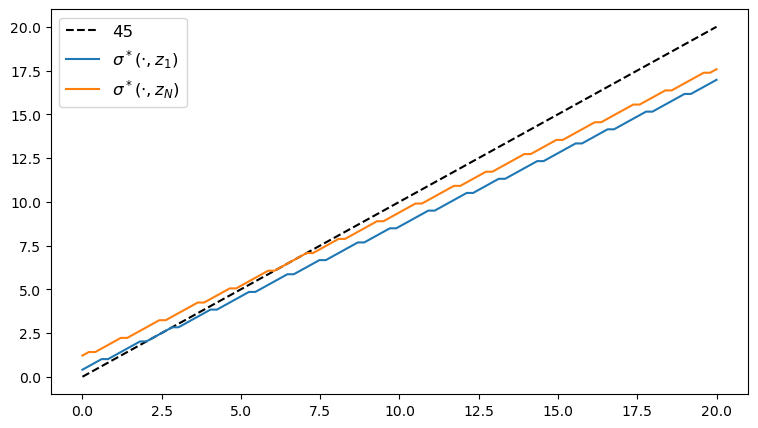

In [21]:
σ_star = policy_iteration(model)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(y_grid, y_grid, "k--", label="45")
ax.plot(y_grid, y_grid[σ_star[:, 1]], label="$\\sigma^*(\cdot, z_1)$")
ax.plot(y_grid, y_grid[σ_star[:, -1]], label="$\\sigma^*(\cdot, z_N)$")
ax.legend(fontsize=12)
plt.show()

Let's plot the time taken by each of the solvers and compare them.

In [22]:
m_vals = range(5, 600, 40)

In [23]:
model = create_investment_model()
print("Running Howard policy iteration.")
qe.tic()
σ_pi = policy_iteration(model)
pi_time = qe.toc()

Running Howard policy iteration.
Concluded loop 1 with error 50.
Concluded loop 2 with error 26.
Concluded loop 3 with error 17.
Concluded loop 4 with error 10.
Concluded loop 5 with error 7.
Concluded loop 6 with error 4.
Concluded loop 7 with error 3.
Concluded loop 8 with error 1.
Concluded loop 9 with error 1.
Concluded loop 10 with error 1.
Concluded loop 11 with error 1.
Concluded loop 12 with error 0.
TOC: Elapsed: 0:00:0.06


In [24]:
print(f"PI completed in {pi_time} seconds.")
print("Running value function iteration.")
qe.tic()
σ_vfi = value_iteration(model, tol=1e-5)
vfi_time = qe.toc()
print(f"VFI completed in {vfi_time} seconds.")

PI completed in 0.06407737731933594 seconds.
Running value function iteration.
TOC: Elapsed: 0:00:0.07
VFI completed in 0.07216668128967285 seconds.


In [25]:
opi_times = []
for m in m_vals:
    print(f"Running optimistic policy iteration with m={m}.")
    qe.tic()
    σ_opi = optimistic_policy_iteration(model, m=m, tol=1e-5)
    opi_time = qe.toc()
    print(f"OPI with m={m} completed in {opi_time} seconds.")
    opi_times.append(opi_time)

Running optimistic policy iteration with m=5.


TOC: Elapsed: 0:00:1.12
OPI with m=5 completed in 1.1297650337219238 seconds.
Running optimistic policy iteration with m=45.


TOC: Elapsed: 0:00:0.95
OPI with m=45 completed in 0.9561493396759033 seconds.
Running optimistic policy iteration with m=85.


TOC: Elapsed: 0:00:0.99
OPI with m=85 completed in 0.9999616146087646 seconds.
Running optimistic policy iteration with m=125.


TOC: Elapsed: 0:00:1.03
OPI with m=125 completed in 1.036729097366333 seconds.
Running optimistic policy iteration with m=165.


TOC: Elapsed: 0:00:1.14
OPI with m=165 completed in 1.1485474109649658 seconds.
Running optimistic policy iteration with m=205.


TOC: Elapsed: 0:00:1.29
OPI with m=205 completed in 1.2931492328643799 seconds.
Running optimistic policy iteration with m=245.


TOC: Elapsed: 0:00:1.39
OPI with m=245 completed in 1.3931818008422852 seconds.
Running optimistic policy iteration with m=285.


TOC: Elapsed: 0:00:1.51
OPI with m=285 completed in 1.5128016471862793 seconds.
Running optimistic policy iteration with m=325.


TOC: Elapsed: 0:00:1.70
OPI with m=325 completed in 1.7029333114624023 seconds.
Running optimistic policy iteration with m=365.


TOC: Elapsed: 0:00:1.94
OPI with m=365 completed in 1.9467973709106445 seconds.
Running optimistic policy iteration with m=405.


TOC: Elapsed: 0:00:2.15
OPI with m=405 completed in 2.15097975730896 seconds.
Running optimistic policy iteration with m=445.


TOC: Elapsed: 0:00:2.36
OPI with m=445 completed in 2.3671889305114746 seconds.
Running optimistic policy iteration with m=485.


TOC: Elapsed: 0:00:2.54
OPI with m=485 completed in 2.5419766902923584 seconds.
Running optimistic policy iteration with m=525.


TOC: Elapsed: 0:00:2.76
OPI with m=525 completed in 2.7646234035491943 seconds.
Running optimistic policy iteration with m=565.


TOC: Elapsed: 0:00:2.97
OPI with m=565 completed in 2.9790232181549072 seconds.


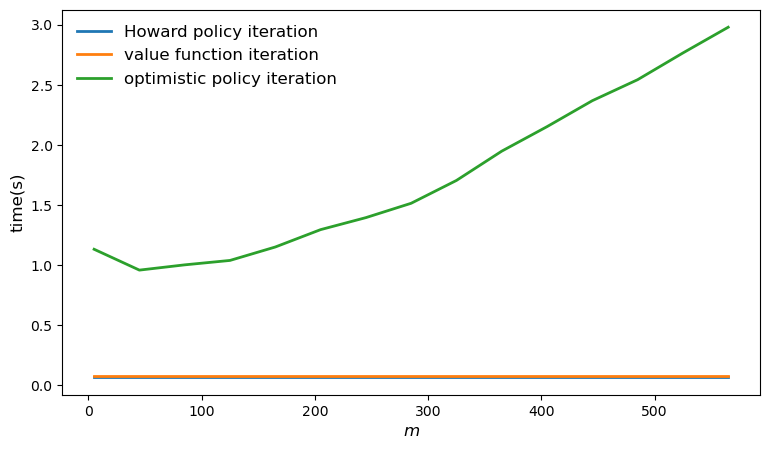

In [26]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(m_vals, jnp.full(len(m_vals), pi_time),
        lw=2, label="Howard policy iteration")
ax.plot(m_vals, jnp.full(len(m_vals), vfi_time),
        lw=2, label="value function iteration")
ax.plot(m_vals, opi_times, lw=2, label="optimistic policy iteration")
ax.legend(fontsize=12, frameon=False)
ax.set_xlabel("$m$", fontsize=12)
ax.set_ylabel("time(s)", fontsize=12)
plt.show()